In [1]:
import joblib
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

data = joblib.load("../benchmark_v1.1/smaht.mims.jl")

In [35]:
subset = data[data['svlen'] <= 50000].copy()
len(subset)

65120

In [36]:
import sys
import numpy as np

subset['signed_svlen'] = np.where(
    subset['svtype'] == 'DEL',
    -subset['svlen'],
    subset['svlen']
)

SZBINS_I = ['[50,100)', '[100,200)', '[200,300)', '[300,400)',
            '[400,600)', '[600,800)', '[800,1k)', '[1k,2.5k)', '[2.5k,5k)', '>=5k']
SZBINS_D = ['<=5k', '(5k,2.5k]', '(2.5k, 1k]', '(1k,800]', '(800,600]', '(600,400]',
            '(400,300]', '(300,200]', '(200,100]', '(100,50]']

SZBINMAX_I = [50, 100, 200, 300, 400, 600, 800, 1000, 2500, 5000, sys.maxsize]
SZBINMAX_D = [-1 * _ for _ in SZBINMAX_I[::-1]]

# Bin function
def assign_szbin(val):
    if val >= 0:
        return pd.cut([val], bins=SZBINMAX_I, labels=SZBINS_I, right=False)[0]
    else:
        return pd.cut([val], bins=SZBINMAX_D, labels=SZBINS_D, right=True)[0]
    
subset['signed_szbin'] = pd.Categorical(
    subset['signed_svlen'].apply(assign_szbin),
    categories=SZBINS_D + SZBINS_I, 
    ordered=True)

def get_vaf_bin(vaf, bins=[0, 0.05, 0.3, 1], labels=["<5%", "5%-30%", "Germline"]):
    """
    Bin VAFs and apply labels
    """
    return pd.cut(vaf, bins=bins, labels=labels) 
subset['VAF_bin'] = get_vaf_bin(subset['VAF_alt'])

In [10]:
x = subset['TRF'].value_counts()
x[True] / len(subset)

0.6677364864864865

In [11]:
x = subset['NumNeighbors'] != 0
x.sum() / len(subset)

0.7140202702702703

In [12]:
(x & subset['TRF']).sum() / len(subset)

0.5403101965601965

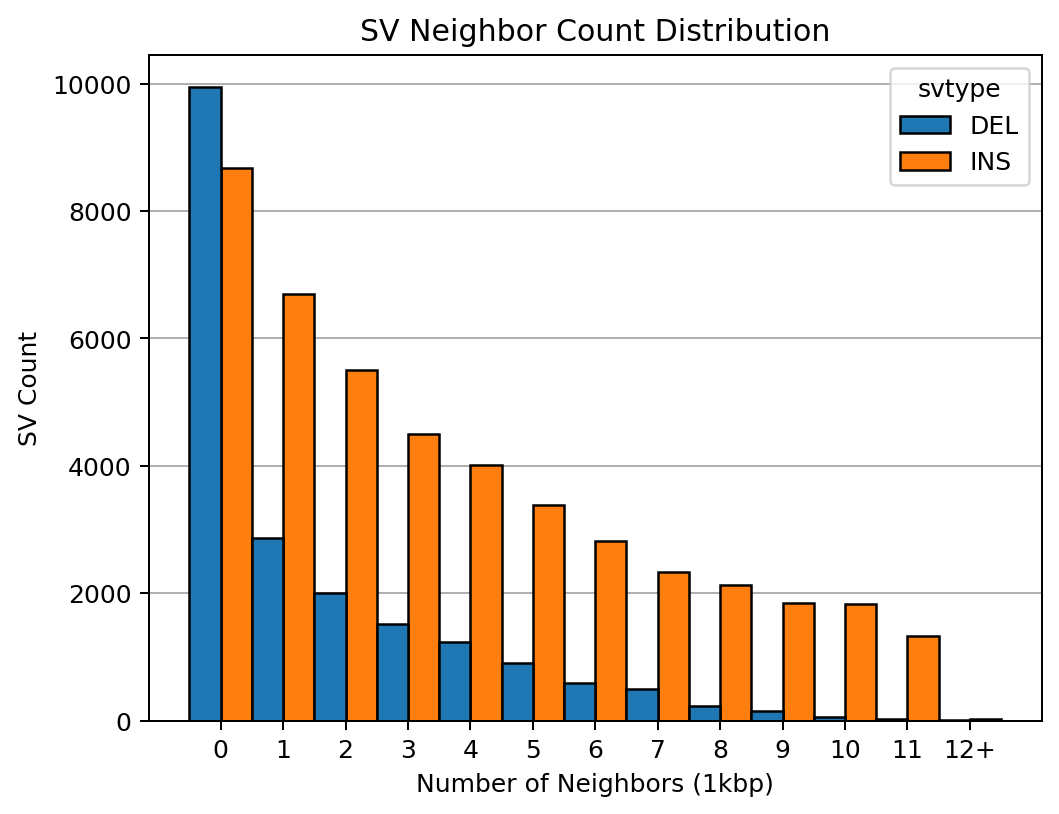

In [26]:
subset = subset.copy()
subset['NumNeighborsCapped'] = subset['NumNeighbors'].clip(upper=12)

plt.figure(dpi=180)
p = sb.histplot(data=subset, 
                x='NumNeighborsCapped', 
                hue='svtype',
                hue_order=['DEL', 'INS'],
                multiple="dodge", 
                binwidth=1,
                discrete=True,
                zorder=2,
                alpha=1)

plt.grid(axis='y', zorder=1)

# Update x-axis ticks to show '12+' for the last bin
xticks = list(range(0, 12)) + ['12+']
p.set_xticks(range(13))
p.set_xticklabels(xticks)
_ = p.set(title="SV Neighbor Count Distribution", xlabel="Number of Neighbors (1kbp)", ylabel="SV Count")

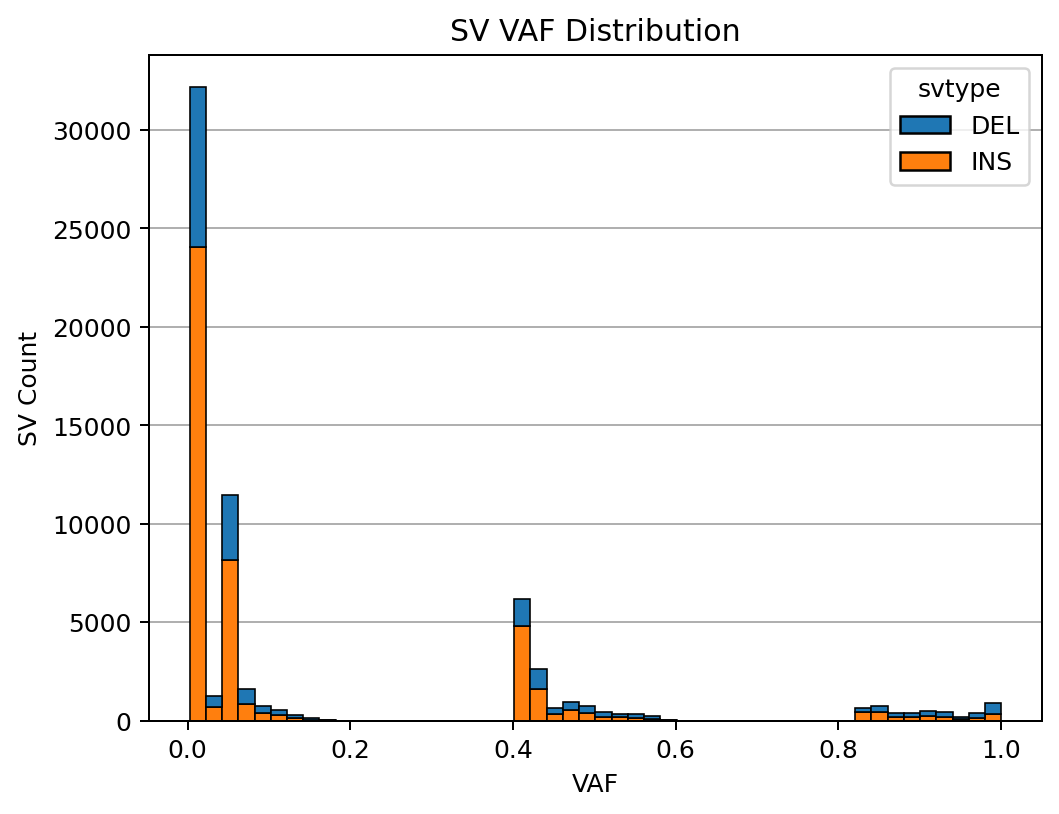

In [40]:
plt.figure(dpi=180)
p = sb.histplot(data=subset,
            x='VAF_alt',
           hue="svtype",
           hue_order=['DEL', 'INS'],
           multiple='stack',
           zorder=2,
           binwidth=0.02, 
                alpha=1)
plt.grid(axis='y', zorder=1)
_ = p.set(title="SV VAF Distribution", ylabel="SV Count", xlabel="VAF")

In [43]:
(subset['VAF_alt'] >= 0.3).sum()

16893

In [44]:
(subset['VAF_alt'] >= 0.3).mean()

0.25941339066339064

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1682/4053348032.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(plot_df[col]):
/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1682/4053348032.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(plot_df[col]):


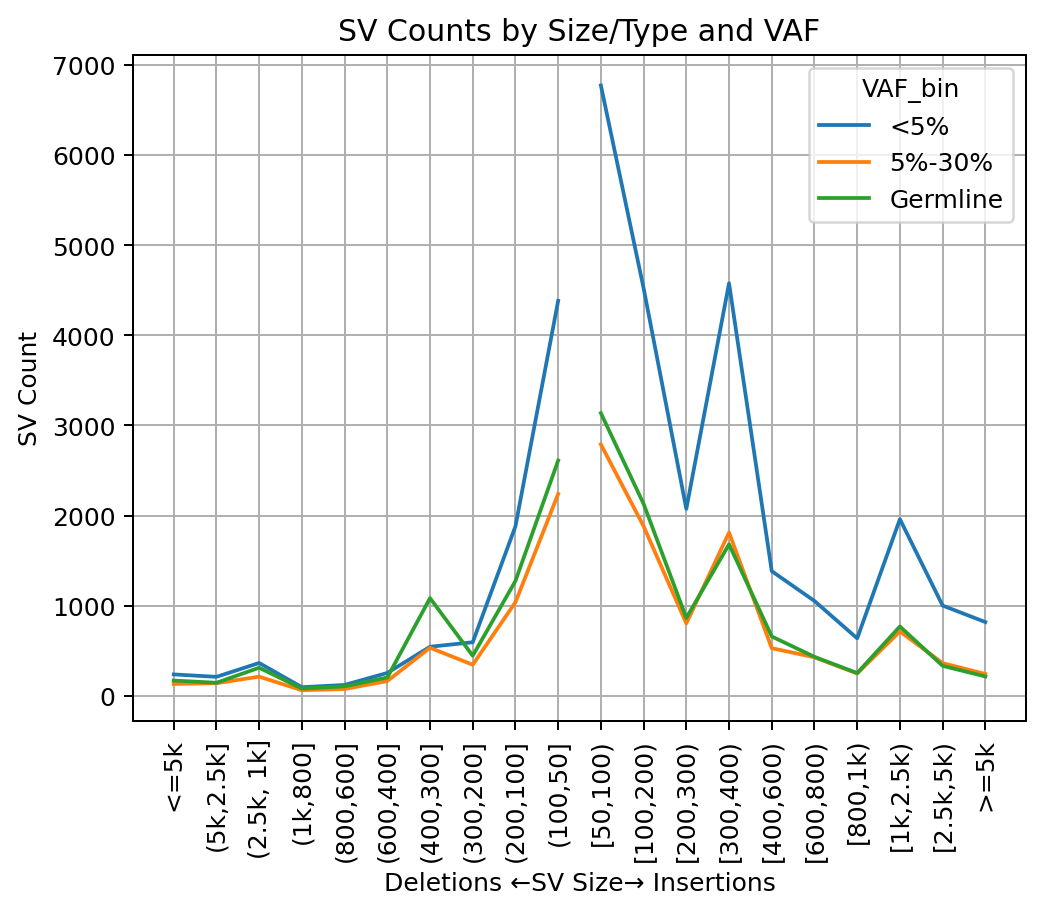

In [57]:
import seaborn as sb
import matplotlib.pyplot as plt
import truvari

plt.figure(dpi=180)

for i in ['DEL', 'INS']:
    plot_df = subset[subset['svtype'] == i].groupby(['signed_szbin', 'VAF_bin'], observed=True).size().reset_index(name='count')

    # Step 2: Drop unused categories
    for col in ['signed_szbin', 'VAF_bin']:
        if pd.api.types.is_categorical_dtype(plot_df[col]):
            plot_df[col] = plot_df[col].cat.remove_unused_categories()
    # Create the plot
    p = sb.lineplot(
        data=plot_df,
        x='signed_szbin',
        y='count',
        hue='VAF_bin',
        markers=False,
        dashes=True,
        legend=(i=='DEL'),
    )

p.set_title("SV Counts by Size/Type and VAF")
p.set_ylabel("Count")
p.set_xlabel("Size Bin")
p.grid(True)
plt.xticks(rotation=90)
_ = p.set(ylabel="SV Count", xlabel='Deletions ←SV Size→ Insertions')

In [44]:
subset[subset['svtype'] == 'DEL'].groupby(['szbin', 'VAF_bin']).size().unstack()

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1682/1011298287.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset[subset['svtype'] == 'DEL'].groupby(['szbin', 'VAF_bin']).size().unstack()


VAF_bin,<5%,5%-30%,Germline
szbin,,,
SNP,0,0,0
"[1,5)",0,0,0
"[5,10)",0,0,0
"[10,15)",0,0,0
"[15,20)",0,0,0
"[20,30)",0,0,0
"[30,40)",0,0,0
"[40,50)",0,0,0
"[50,100)",4384,2240,2611
